Part 1 - Q5 - Transformers
===

I did not have time to finish, please don't look at this colab.

//

Inspiration:

*  https://keras.io/examples/timeseries/timeseries_classification_transformer/
*  https://machinelearningmastery.com/implementing-the-transformer-encoder-from-scratch-in-tensorflow-and-keras/




In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [17]:
%matplotlib inline
import torch
import torch.nn.functional as F

In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [19]:
import param
import panel as pn
pn.extension()
import datetime as dt
import importlib
from importlib import reload
from tqdm import tqdm

In [30]:
from keras.layers import MultiHeadAttention, Attention
from keras.layers import LayerNormalization, Layer
from keras.layers import Add, Multiply


In [21]:
import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,Dense,LSTM,Dropout,Flatten,BatchNormalization,Conv1D,MaxPooling1D
from keras.optimizers import  SGD
from keras.optimizers import  RMSprop
from keras.regularizers import l2
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing import sequence
from tensorflow.keras.layers import Bidirectional
from keras.losses import BinaryFocalCrossentropy
from keras.models import Model
from keras.layers import Input
from torchmetrics.classification import BinaryF1Score
from sklearn.metrics import accuracy_score, balanced_accuracy_score

In [22]:
import graph as gr
import params as par
import py_lib as lib
reload(gr)
reload(par)
reload(lib)
import graph as gr
import params as par
import py_lib as lib

In [23]:
format_dict = par.create_format_dict()

In [24]:
class NotebookParams(param.Parameterized):
    lambda_multiple          = param.Number(1, bounds=(1,10), doc="lambda Lasso Multiple of 10^x")
    lambda_power             = param.Integer(default=2, bounds=(1,7),doc="lambda Lasso exponent of 10^x")
    lr_multiple              = param.Number(5, bounds=(1,10), doc="Learning Rate Multiple of 10^x")
    lr_power                 = param.Integer(default=3, bounds=(1,9),doc="Learning Rate exponent of 10^x")
    epochs                   = param.Integer(default=2000 ,bounds=(1,2000))
    data_set                 = param.ObjectSelector(default="test",objects=['train', 'validation', 'train + validation', 'test'])
    stand_features           = param.Boolean(False, doc="Whether we want to standardize numerical features")
    use_lasso                = param.Boolean(True)
    use_focal_loss           = param.Boolean(True)
    iter_array               = param.Integer(default=5, bounds=(1,20),doc="How often to save loss and training data, in epochs")
    iter_printing            = param.Integer(default=5, bounds=(1,100),doc="How many epochs between printing")
    add_one_hot_encoded      = param.Boolean(False, doc="Whether to add one hot encoded columns from categorical variables")
    test_size                = param.Number(0.2, bounds=(0.1,0.9), doc="Test size for train_test_split")
    random_state_test_train_split = param.Integer(42)
base = NotebookParams()

# Import Data

In [25]:
df_heart_test = pd.read_csv('../data_proj2/ptbdb_test.csv', header=None)
df_heart_train = pd.read_csv('../data_proj2/ptbdb_train.csv', header=None)

In [26]:
df_heart_train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.730599,0.472859,0.139526,0.000000,0.020507,0.112183,0.162847,0.180941,0.192199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.152446,0.011377,0.308305,0.153584,0.096701,0.083049,0.086462,0.105802,0.071672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.975917,0.693234,0.241399,0.107225,0.098050,0.072248,0.062500,0.054472,0.054472,0.045872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Features preprocessing

In [28]:
x_train_0, x_test_0, y_train_0, y_test_0, lstm_input = lib.pre_process_ecg(
        df_heart_train,
        label_col_pos=-1,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        split_data=True,
				with_lstm_transfo=True,
)

# Transformer

In [36]:
class FeedForward(Layer):
		def __init__(self, d_ff, d_model, **kwargs):
				super(FeedForward, self).__init__(**kwargs)
				self.fully_connected1 = Dense(d_ff)  # First fully connected layer
				self.fully_connected2 = Dense(d_model)  # Second fully connected layer
				self.activation = ReLU()  # ReLU activation layer

		def call(self, x):
				# The input is passed into the two fully-connected layers, with a ReLU in between
				x_fc1 = self.fully_connected1(x)

				return self.fully_connected2(self.activation(x_fc1))

In [37]:
class AddNormalization(Layer):
		def __init__(self, **kwargs):
				super(AddNormalization, self).__init__(**kwargs)
				self.layer_norm = LayerNormalization()  # Layer normalization layer

		def call(self, x, sublayer_x):
				# The sublayer input and output need to be of the same shape to be summed
				add = x + sublayer_x
		
				# Apply layer normalization to the sum
				return self.layer_norm(add)

In [40]:
class EncoderLayer(Layer):
		def __init__(self, h, d_k, d_v, d_model, d_ff, rate, **kwargs):
				super(EncoderLayer, self).__init__(**kwargs)
				self.multihead_attention = MultiHeadAttention(h, d_k, d_v, d_model)
				self.dropout1 = Dropout(rate)
				self.add_norm1 = AddNormalization()
				self.feed_forward = FeedForward(d_ff, d_model)
				self.dropout2 = Dropout(rate)
				self.add_norm2 = AddNormalization()

		def call(self, x, padding_mask, training):
				# Multi-head attention layer
				multihead_output = self.multihead_attention(x, x, x, padding_mask)
				# Expected output shape = (batch_size, sequence_length, d_model)
		
				# Add in a dropout layer
				multihead_output = self.dropout1(multihead_output, training=training)
		
				# Followed by an Add & Norm layer
				addnorm_output = self.add_norm1(x, multihead_output)
				# Expected output shape = (batch_size, sequence_length, d_model)
		
				# Followed by a fully connected layer
				feedforward_output = self.feed_forward(addnorm_output)
				# Expected output shape = (batch_size, sequence_length, d_model)
		
				# Add in another dropout layer
				feedforward_output = self.dropout2(feedforward_output, training=training)
		
				# Followed by another Add & Norm layer
				return self.add_norm2(addnorm_output, feedforward_output)

In [44]:
class PositionEmbeddingFixedWeights(Layer):
    def __init__(self, sequence_length, vocab_size, output_dim, **kwargs):
        super(PositionEmbeddingFixedWeights, self).__init__(**kwargs)
        word_embedding_matrix = self.get_position_encoding(vocab_size, output_dim)   
        position_embedding_matrix = self.get_position_encoding(sequence_length, output_dim)                                          
        self.word_embedding_layer = Embedding(
            input_dim=vocab_size, output_dim=output_dim,
            weights=[word_embedding_matrix],
            trainable=False
        )
        self.position_embedding_layer = Embedding(
            input_dim=sequence_length, output_dim=output_dim,
            weights=[position_embedding_matrix],
            trainable=False
        )
             
    def get_position_encoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k, 2*i] = np.sin(k/denominator)
                P[k, 2*i+1] = np.cos(k/denominator)
        return P
 
 
    def call(self, inputs):        
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return embedded_words + embedded_indices

In [41]:
class Encoder(Layer):
		def __init__(self, vocab_size, sequence_length, h, d_k, d_v, d_model, d_ff, n, rate, **kwargs):
				super(Encoder, self).__init__(**kwargs)
				self.pos_encoding = PositionEmbeddingFixedWeights(sequence_length, vocab_size, d_model)
				self.dropout = Dropout(rate)
				self.encoder_layer = [EncoderLayer(h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]


		def call(self, input_sentence, padding_mask, training):
				# Generate the positional encoding
				pos_encoding_output = self.pos_encoding(input_sentence)
				# Expected output shape = (batch_size, sequence_length, d_model)
		
				# Add in a dropout layer
				x = self.dropout(pos_encoding_output, training=training)
		
				# Pass on the positional encoded values to each encoder layer
				for i, layer in enumerate(self.encoder_layer):
						x = layer(x, padding_mask, training)
		
				return x

In [42]:
h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_ff = 2048  # Dimensionality of the inner fully connected layer
d_model = 512  # Dimensionality of the model sub-layers' outputs
n = 6  # Number of layers in the encoder stack
 
batch_size = 64  # Batch size from the training process
dropout_rate = 0.1  # Frequency of dropping the input units in the dropout layers
       

In [45]:
from numpy import random
 
enc_vocab_size = 20 # Vocabulary size for the encoder
input_seq_length = 5  # Maximum length of the input sequence
h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_ff = 2048  # Dimensionality of the inner fully connected layer
d_model = 512  # Dimensionality of the model sub-layers' outputs
n = 6  # Number of layers in the encoder stack
 
batch_size = 64  # Batch size from the training process
dropout_rate = 0.1  # Frequency of dropping the input units in the dropout layers
 
input_seq = random.random((batch_size, input_seq_length))
 
encoder = Encoder(enc_vocab_size, input_seq_length, h, d_k, d_v, d_model, d_ff, n, dropout_rate)
print(encoder(input_seq, None, True))

ValueError: Unrecognized keyword arguments passed to Embedding: {'weights': [array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 8.41470985e-01,  5.40302306e-01,  8.21856190e-01, ...,
         9.99999994e-01,  1.03663293e-04,  9.99999995e-01],
       [ 9.09297427e-01, -4.16146837e-01,  9.36414739e-01, ...,
         9.99999977e-01,  2.07326584e-04,  9.99999979e-01],
       ...,
       [-9.61397492e-01, -2.75163338e-01, -6.37527146e-01, ...,
         9.99998331e-01,  1.76227507e-03,  9.99998447e-01],
       [-7.50987247e-01,  6.60316708e-01, -9.96376966e-01, ...,
         9.99998129e-01,  1.86593819e-03,  9.99998259e-01],
       [ 1.49877210e-01,  9.88704618e-01, -4.97734823e-01, ...,
         9.99997916e-01,  1.96960129e-03,  9.99998060e-01]])]}

## Model Building

In [14]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [15]:
# Computing the alpha for focal loss
class_weights = y_train_0.value_counts() / len(y_train_0)
class_weights = 1-class_weights
alpha_focal_loss = class_weights.loc[1.0].values[0]

NameError: name 'y_train_0' is not defined

In [247]:
def build_model(
	n_filters=32,
	kernel_size=3,
	pool_size=2,
	learning_rate=0.001,
	lstm_dropout=0.7,
	recurrent_dropout = 0.7,
	final_dropout = 0.2,
	clipnorm=0.5,
	use_focal=False,
	use_bidirectional=False,
	use_sgd_opt=False,
	use_rms_opt=False,
	alpha_focal_loss=0.25,
	with_second_layers_group=False,
):
	if use_sgd_opt:
		opt = SGD(learning_rate=learning_rate, clipnorm=clipnorm)
	elif use_rms_opt:
		opt = RMSprop(learning_rate=learning_rate, clipnorm=clipnorm)
	else:
		opt = Adam(learning_rate=learning_rate)


	model = Sequential()
	model.add(Conv1D(
		filters=n_filters,
		kernel_size=kernel_size, strides=1, input_shape=(187,1), padding = 'same', activation = 'relu'
		))
	model.add(MaxPooling1D(pool_size=pool_size , strides = 1 , padding = 'same'))
	model.add(BatchNormalization())

	if with_second_layers_group:
		model.add(Conv1D(
			filters=n_filters*2,
			kernel_size=kernel_size, strides=1, padding = 'same', activation = 'relu'
			))
		model.add(MaxPooling1D(pool_size=pool_size , strides = 1 , padding = 'same'))
		model.add(BatchNormalization())	
	model.add(Dropout(final_dropout))
	model.add(Flatten())
	model.add(Dense(units = 1 , activation = 'sigmoid'))
	if use_focal:
		model.compile(loss=BinaryFocalCrossentropy(alpha=alpha_focal_loss), optimizer=opt, metrics=['accuracy'])
	else:
		model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	print(model.summary())
	return model

In [227]:
model_cnn=build_model(
	n_filters=64,
	kernel_size=4,
	pool_size=2,
	learning_rate=0.02,
	use_focal=True,
	use_bidirectional=False,
	lstm_dropout=0.7,
	recurrent_dropout = 0.7,
	final_dropout = 0.7,
	clipnorm = 0.5,
	use_sgd_opt=False,
	use_rms_opt=True,
	with_second_layers_group=True,
	alpha_focal_loss=alpha_focal_loss,
    )

/home/pinolej/.venv_2/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_28 (Conv1D)              │ (None, 187, 64)        │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 187, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 187, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 187, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 187, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 187, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 187, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 23936)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │        23,937 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,921 (226.25 KB)

 Trainable params: 57,537 (224.75 KB)

 Non-trainable params: 384 (1.50 KB)

None


## Training

In [228]:
es = EarlyStopping(monitor='val_loss', mode='min',patience=5)
history = model_cnn.fit(
	lstm_input['x_train'],
	lstm_input['y_train'],
	epochs=20,
	batch_size=64*1,
	validation_data=(lstm_input['x_test'], lstm_input['y_test']),
	callbacks = [learning_rate_reduction],
	shuffle=False,
    )



Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 26s 144ms/step - accuracy: 0.6722 - loss: 17.8145 - val_accuracy: 0.2799 - val_loss: 0.5287 - learning_rate: 0.0200
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 46s 178ms/step - accuracy: 0.6661 - loss: 1.1368 - val_accuracy: 0.7772 - val_loss: 0.1553 - learning_rate: 0.0200
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.7109 - loss: 1.0064 - val_accuracy: 0.7201 - val_loss: 3.2142 - learning_rate: 0.0200
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7315 - loss: 0.9776
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.005999999865889549.
146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 145ms/step - accuracy: 0.7315 - loss: 0.9776 - val_accuracy: 0.7209 - val_loss: 1.5691 - learning_rate: 0.0200
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step - accuracy: 0.8293 - loss: 0.2652 - val_accuracy: 0.7492 - val_loss: 0.1665 - learning_rate: 0.0060
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8131

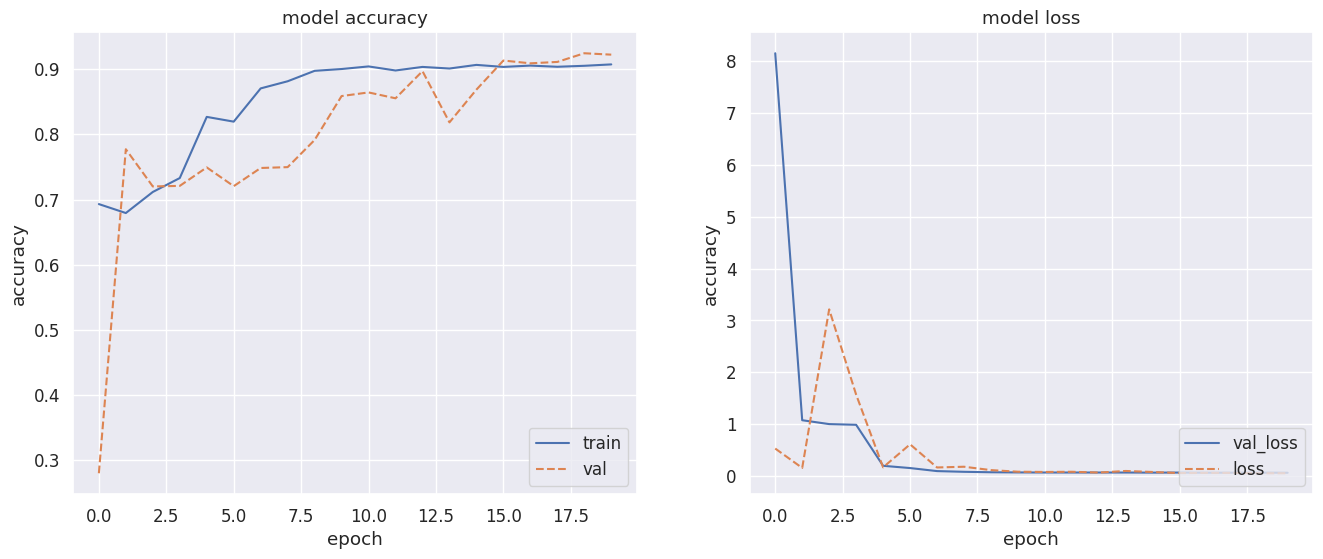

In [231]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

In [225]:
# # equivalent to: model.save("model.h5")
# from tensorflow.keras.models import save_model
# # save_model(model, "model_second_save.h5")
# # save model and architecture to single file
# model_cnn.save("cnn_simple.h5")
# model_cnn.save('cnn_simple.keras')
# print("Saved model to disk")


Saved model to disk


## Evaluation

In [166]:
_, _, _, _, lstm_input_eval = lib.pre_process_ecg(
        df_heart_test,
        label_col_pos=-1,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        split_data=False,
				with_lstm_transfo=True,
)

In [232]:
y_pred = model_cnn.predict(lstm_input_eval['x_train'])
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_pred_df = pd.DataFrame(y_pred.round())
y_pred_df.value_counts()

 9/91 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


0  
1.0    2154
0.0     757
Name: count, dtype: int64

In [233]:
y_pred_tensor, y_pred_round, y_pred_round_tensor = lib.process_for_eval_from_single_proba_array(y_pred)
y_true = torch.from_numpy(lstm_input_eval['y_train'])

In [234]:
acc = accuracy_score(y_true, y_pred_round, normalize = True)  
bal_acc=balanced_accuracy_score(y_true, y_pred_round)
f1_score = BinaryF1Score()
f1 = f1_score(y_pred_round_tensor, y_true).numpy()
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [235]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,91.5%,88.5%,94.2%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

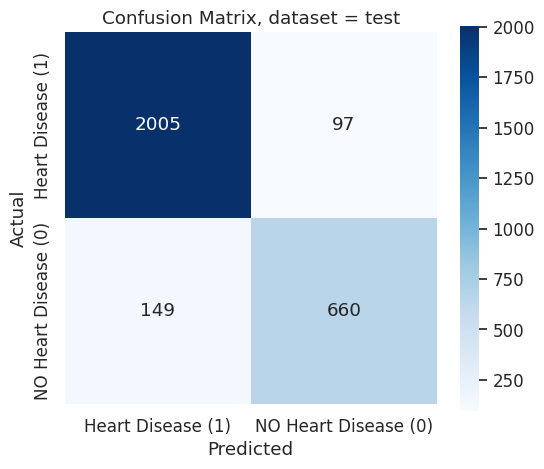

In [240]:
logreg_conf_matrix = confusion_matrix(y_true, y_pred_round)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

In [241]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc_performance = auc(fpr, tpr)

In [242]:
import graph as gr
reload(gr)
import graph as gr

/home/pinolej/eth/healthcare/proj3/task_1/graph.py:303: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)
/home/pinolej/eth/healthcare/proj3/task_1/graph.py:305: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)


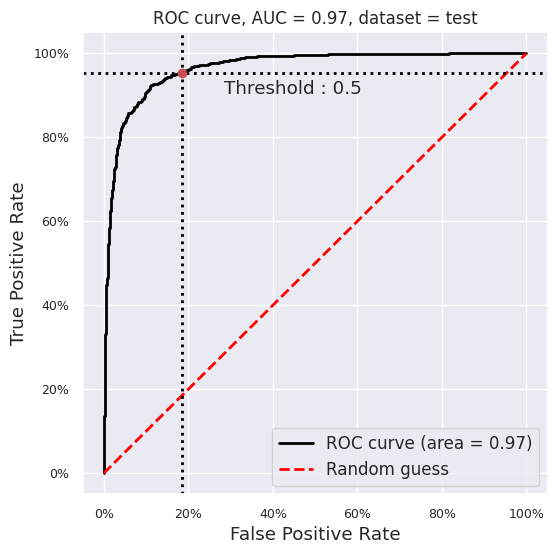

In [243]:
gr.custom_roc_curve(
        fpr,
        tpr,
        thresholds,
        thresholds_to_plot=[0.5],
        figsize=(6,6),
        fontsize={
            'ax_title': 12,
        },
        dataset_type=base.data_set,
        auc_performance=auc_performance,
        y_text_margin=0.05,
        x_text_margin=0.1,
        plot_threshold=True,
)

## Model Building

In [244]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [245]:
# Computing the alpha for focal loss
class_weights = y_train_0.value_counts() / len(y_train_0)
class_weights = 1-class_weights
alpha_focal_loss = class_weights.loc[1.0].values[0]

In [286]:
def cnn_with_residual_blocks(
	input_shape = (187,1),
	n_filters=32,
	kernel_size=3,
	pool_size=2,
	learning_rate=0.001,
	final_dropout = 0.2,
	with_second_layers_group=False,
	):
	# Define the input as a tensor with shape input_shape
	input = Input(input_shape)

	# Stage 1
	fx = Conv1D(filters=n_filters, kernel_size=kernel_size, strides=1, padding = 'same', activation = 'relu')(input)
	fx = MaxPooling1D(pool_size=pool_size , strides = 1 , padding = 'same')(fx)
	fx = BatchNormalization()(fx)

	# Stage 2
	if with_second_layers_group:
		fx = Conv1D(filters=n_filters, kernel_size=kernel_size, strides=1, padding = 'same', activation = 'relu')(fx)
		fx = MaxPooling1D(pool_size=pool_size , strides = 1 , padding = 'same')(fx)
		fx = BatchNormalization()(fx)

	# Combining the two blocks
	out = Add()([input,fx])

	# Output layer
	out = Dropout(final_dropout)(out)
	out = Flatten()(out)
	out = Dense(units = 1 , activation = 'sigmoid')(out)

	# Create model
	model = Model(inputs = input, outputs = out, name='ResNet50')
	return model

In [287]:
def compile_cnn_with_residual_blocks(
	n_filters=64,
	kernel_size=4,
	pool_size=2,
	learning_rate=0.02,
	use_focal=True,
	use_bidirectional=False,
	lstm_dropout=0.7,
	recurrent_dropout = 0.7,
	final_dropout = 0.7,
	clipnorm = 0.5,
	use_sgd_opt=False,
	use_rms_opt=True,
	with_second_layers_group=True,
	alpha_focal_loss=alpha_focal_loss,
):

	model_resnet = cnn_with_residual_blocks(
		n_filters=n_filters,
		kernel_size=kernel_size,
		pool_size=pool_size,
		final_dropout=final_dropout,
		with_second_layers_group=with_second_layers_group,
	)

	if use_sgd_opt:
		opt = SGD(learning_rate=learning_rate, clipnorm=clipnorm)
	elif use_rms_opt:
		opt = RMSprop(learning_rate=learning_rate, clipnorm=clipnorm)
	else:
		opt = Adam(learning_rate=learning_rate)

	model_resnet.summary()
	if use_focal:
		model_resnet.compile(loss=BinaryFocalCrossentropy(alpha=alpha_focal_loss), optimizer=opt, metrics=['accuracy'])
	else:
		model_resnet.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model_resnet

In [293]:
model_resnet=compile_cnn_with_residual_blocks(
	n_filters=64,
	kernel_size=4,
	pool_size=2,
	learning_rate=0.02,
	use_focal=True,
	final_dropout = 0.7,
	clipnorm = 0.5,
	use_sgd_opt=False,
	use_rms_opt=True,
	with_second_layers_group=False,
	alpha_focal_loss=alpha_focal_loss,
	)

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29      │ (None, 187, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 187, 64)   │        320 │ input_layer_29[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_38    │ (None, 187, 64)   │          0 │ conv1d_41[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 64)   │        256 │ max_pooling1d_38… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 187, 64)   │          0 │ input_layer_29[0… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 187, 64)   │          0 │ add_4[0][0]       │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_16          │ (None, 11968)     │          0 │ dropout_30[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 1)         │     11,969 │ flatten_16[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,545 (49.00 KB)

 Trainable params: 12,417 (48.50 KB)

 Non-trainable params: 128 (512.00 B)

In [294]:
# from keras.utils import plot_model
# plot_model(model_resnet, "my_first_model_with_shape_info.png", show_shapes=True)

## Training

In [298]:
es = EarlyStopping(monitor='val_loss', mode='min',patience=5)
history = model_resnet.fit(
	lstm_input['x_train'],
	lstm_input['y_train'],
	epochs=20,
	batch_size=64*1,
	validation_data=(lstm_input['x_test'], lstm_input['y_test']),
	callbacks = [learning_rate_reduction],
	shuffle=False,
    )



Epoch 1/20


146/146 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.8083 - loss: 0.3303 - val_accuracy: 0.7802 - val_loss: 0.6974 - learning_rate: 5.4000e-04
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.8106 - loss: 0.2940 - val_accuracy: 0.7759 - val_loss: 0.6008 - learning_rate: 5.4000e-04
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.8217 - loss: 0.2701 - val_accuracy: 0.8386 - val_loss: 0.2219 - learning_rate: 5.4000e-04
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.8246 - loss: 0.2522 - val_accuracy: 0.8605 - val_loss: 0.1525 - learning_rate: 5.4000e-04
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.8244 - loss: 0.2435 - val_accuracy: 0.8768 - val_loss: 0.1180 - learning_rate: 5.4000e-04
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.8292 - loss: 0.2412 - val_accuracy: 0.8235 - val_loss: 0.1831 - learning_rate: 5.4000e-04
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy:

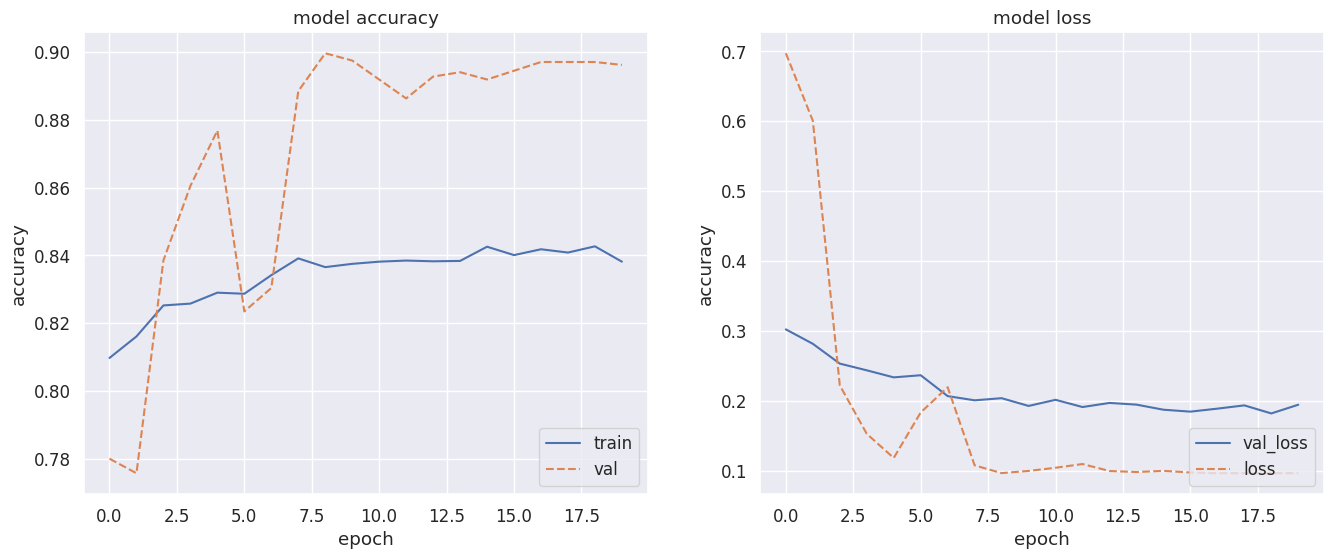

In [302]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

In [315]:
# equivalent to: model.save("model.h5")
# save_model(model, "model_second_save.h5")
# save model and architecture to single file
model_resnet.save("model_resnet.h5")
model_resnet.save('model_resnet.keras')
print("Saved model to disk")


Saved model to disk


## Evaluation

In [303]:
_, _, _, _, lstm_input_eval = lib.pre_process_ecg(
        df_heart_test,
        label_col_pos=-1,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        split_data=False,
				with_lstm_transfo=True,
)

In [304]:
y_pred = model_resnet.predict(lstm_input_eval['x_train'])
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_pred_df = pd.DataFrame(y_pred.round())
y_pred_df.value_counts()

91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


0  
1.0    2140
0.0     771
Name: count, dtype: int64

In [305]:
y_pred_tensor, y_pred_round, y_pred_round_tensor = lib.process_for_eval_from_single_proba_array(y_pred)
y_true = torch.from_numpy(lstm_input_eval['y_train'])

In [306]:
acc = accuracy_score(y_true, y_pred_round, normalize = True)  
bal_acc=balanced_accuracy_score(y_true, y_pred_round)
f1_score = BinaryF1Score()
f1 = f1_score(y_pred_round_tensor, y_true).numpy()
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [307]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,89.9%,86.7%,93.1%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

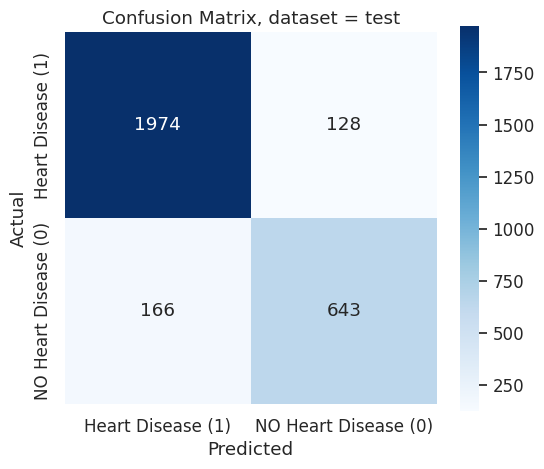

In [308]:
logreg_conf_matrix = confusion_matrix(y_true, y_pred_round)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

In [309]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc_performance = auc(fpr, tpr)

In [310]:
import graph as gr
reload(gr)
import graph as gr

/home/pinolej/eth/healthcare/proj3/task_1/graph.py:303: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)
/home/pinolej/eth/healthcare/proj3/task_1/graph.py:305: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)


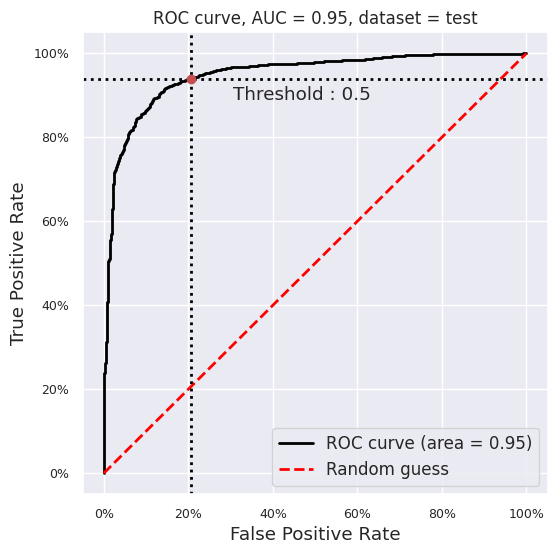

In [311]:
gr.custom_roc_curve(
        fpr,
        tpr,
        thresholds,
        thresholds_to_plot=[0.5],
        figsize=(6,6),
        fontsize={
            'ax_title': 12,
        },
        dataset_type=base.data_set,
        auc_performance=auc_performance,
        y_text_margin=0.05,
        x_text_margin=0.1,
        plot_threshold=True,
)

## Model Building

Note that the functions are defined in the previous section and that here we are only instantiating anoter resnet model, but this time with 2 stages of convolution instead of one.

In [313]:
model_resnet_2_stages=compile_cnn_with_residual_blocks(
	n_filters=64,
	kernel_size=4,
	pool_size=2,
	learning_rate=0.02,
	use_focal=True,
	final_dropout = 0.7,
	clipnorm = 0.5,
	use_sgd_opt=False,
	use_rms_opt=True,
	with_second_layers_group=True,
	alpha_focal_loss=alpha_focal_loss,
	)

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 187, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_42 (Conv1D)  │ (None, 187, 64)   │        320 │ input_layer_30[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_39    │ (None, 187, 64)   │          0 │ conv1d_42[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 64)   │        256 │ max_pooling1d_39… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_43 (Conv1D)  │ (None, 187, 64)   │     16,448 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_40    │ (None, 187, 64)   │          0 │ conv1d_43[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 64)   │        256 │ max_pooling1d_40… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 187, 64)   │          0 │ input_layer_30[0… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 187, 64)   │          0 │ add_5[0][0]       │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_17          │ (None, 11968)     │          0 │ dropout_31[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 1)         │     11,969 │ flatten_17[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,249 (114.25 KB)

 Trainable params: 28,993 (113.25 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
# from keras.utils import plot_model
# plot_model(model_resnet, "my_first_model_with_shape_info.png", show_shapes=True)

## Training

In [314]:
es = EarlyStopping(monitor='val_loss', mode='min',patience=5)
history = model_resnet_2_stages.fit(
	lstm_input['x_train'],
	lstm_input['y_train'],
	epochs=20,
	batch_size=64*1,
	validation_data=(lstm_input['x_test'], lstm_input['y_test']),
	callbacks = [learning_rate_reduction],
	shuffle=False,
    )



Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - accuracy: 0.6749 - loss: 11.7107 - val_accuracy: 0.7201 - val_loss: 12.8101 - learning_rate: 0.0200
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.7493 - loss: 1.9899 - val_accuracy: 0.7093 - val_loss: 1.8670 - learning_rate: 0.0200
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7729 - loss: 1.8131
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.005999999865889549.
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.7729 - loss: 1.8128 - val_accuracy: 0.7196 - val_loss: 5.7323 - learning_rate: 0.0200
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.8308 - loss: 1.0710 - val_accuracy: 0.7793 - val_loss: 1.2927 - learning_rate: 0.0060
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.8451 - loss: 0.7396 - val_accuracy: 0.8089 - val_loss: 0.8423 - learning_rate: 0.0060
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.8505 - lo

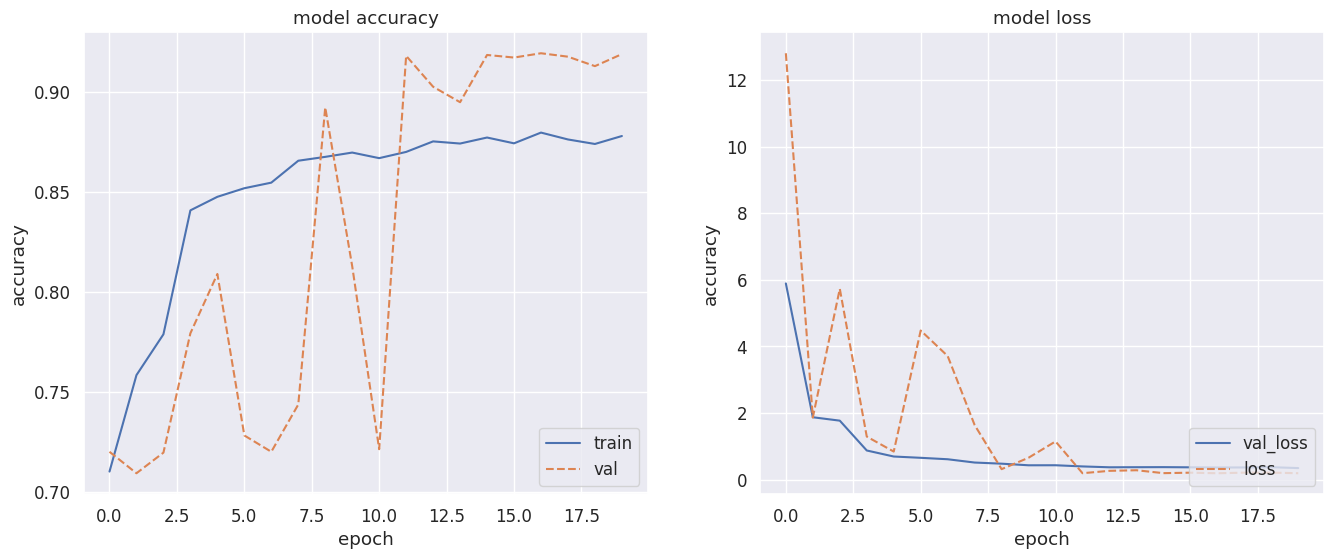

In [316]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

In [326]:
# equivalent to: model.save("model.h5")
model_resnet_2_stages.save("model_resnet_2_stages.h5")
model_resnet_2_stages.save('model_resnet_2_stages.keras')
print("Saved model to disk")

Saved model to disk


## Evaluation

In [317]:
_, _, _, _, lstm_input_eval = lib.pre_process_ecg(
        df_heart_test,
        label_col_pos=-1,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        split_data=False,
				with_lstm_transfo=True,
)

In [318]:
y_pred = model_resnet_2_stages.predict(lstm_input_eval['x_train'])
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_pred_df = pd.DataFrame(y_pred.round())
y_pred_df.value_counts()

91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step


0  
1.0    2124
0.0     787
Name: count, dtype: int64

In [319]:
y_pred_tensor, y_pred_round, y_pred_round_tensor = lib.process_for_eval_from_single_proba_array(y_pred)
y_true = torch.from_numpy(lstm_input_eval['y_train'])

In [320]:
acc = accuracy_score(y_true, y_pred_round, normalize = True)  
bal_acc=balanced_accuracy_score(y_true, y_pred_round)
f1_score = BinaryF1Score()
f1 = f1_score(y_pred_round_tensor, y_true).numpy()
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [321]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,92.0%,89.7%,94.5%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

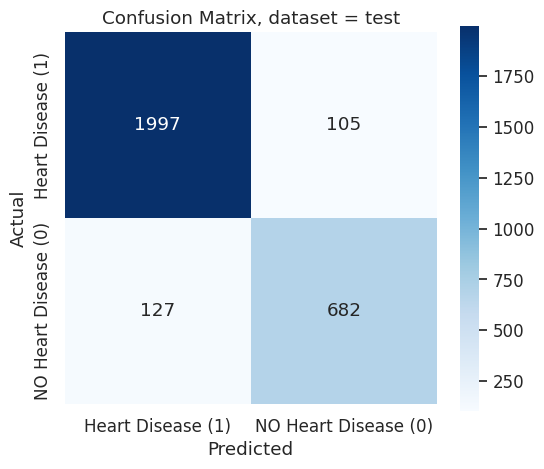

In [322]:
logreg_conf_matrix = confusion_matrix(y_true, y_pred_round)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

In [323]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc_performance = auc(fpr, tpr)

/home/pinolej/eth/healthcare/proj3/task_1/graph.py:303: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)
/home/pinolej/eth/healthcare/proj3/task_1/graph.py:305: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)


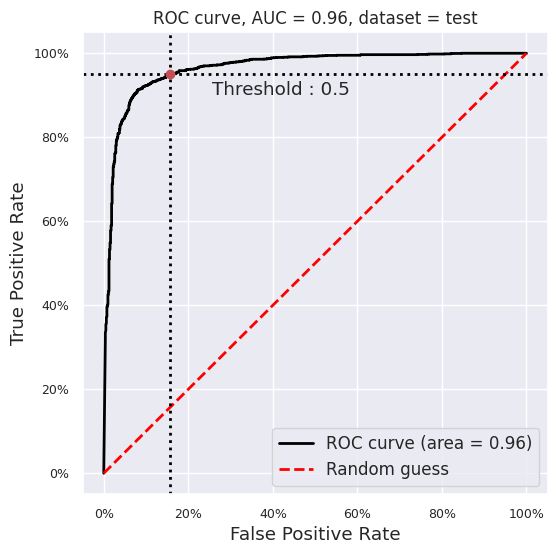

In [325]:
gr.custom_roc_curve(
        fpr,
        tpr,
        thresholds,
        thresholds_to_plot=[0.5],
        figsize=(6,6),
        fontsize={
            'ax_title': 12,
        },
        dataset_type=base.data_set,
        auc_performance=auc_performance,
        y_text_margin=0.05,
        x_text_margin=0.1,
        plot_threshold=True,
)